In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

%matplotlib inline

In [2]:
train = pd.read_csv("./data.csv")

In [3]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245


In [4]:
train['h'] = train['ymax'] - train['ymin']
train['w'] = train['xmax'] - train['xmin']

train['x'] = ( train['w'] // 2 ) + train['xmin']  
train['y'] = ( train['h'] // 2 ) + train['ymin'] 

In [5]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,h,w,x,y
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254,107,112,565,200
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258,112,70,479,202
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328,109,112,401,273
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445,105,120,347,392
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245,91,85,43,199


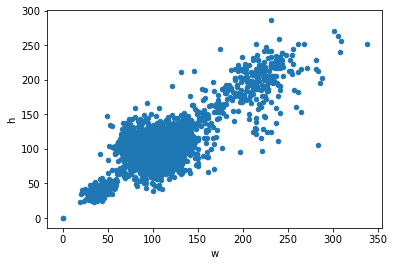

In [6]:
train[['h','w']].plot.scatter(x='w',y='h')

In [7]:
train[['h','w']].max(axis=0)

h    286
w    338
dtype: int64

In [8]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

train['x'],train['w'] = train['x'] / 640,train['w'] / 640
train['y'],train['h'] = train['y'] / 480,train['h'] / 480

In [9]:
train.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,h,w,x,y
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.795312,0.306250,0.970313,0.529167,0.222917,0.175000,0.882812,0.416667
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.693750,0.304167,0.803125,0.537500,0.233333,0.109375,0.748437,0.420833
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.539062,0.456250,0.714063,0.683333,0.227083,0.175000,0.626563,0.568750


In [10]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    group = grouped.get_group(i)
    group = group[group['class']!="RBC"]
    boxes = list(group[['class','x','y','w','h','xmin','ymin','xmax','ymax']].T.to_dict().values())
    
    data.append({
        'filename':i,
        'boxes':boxes
    })
    
data = np.array(data)

In [11]:
data[0]

{'filename': './JPEGImages/BloodImage_00266.jpg',
 'boxes': [{'class': 'WBC',
   'x': 0.146875,
   'y': 0.7145833333333333,
   'w': 0.2890625,
   'h': 0.40208333333333335,
   'xmin': 0.003125,
   'ymin': 0.5145833333333333,
   'xmax': 0.2921875,
   'ymax': 0.9166666666666666},
  {'class': 'Platelets',
   'x': 0.9390625,
   'y': 0.9145833333333333,
   'w': 0.06875,
   'h': 0.06875,
   'xmin': 0.9046875,
   'ymin': 0.88125,
   'xmax': 0.9734375,
   'ymax': 0.95}]}

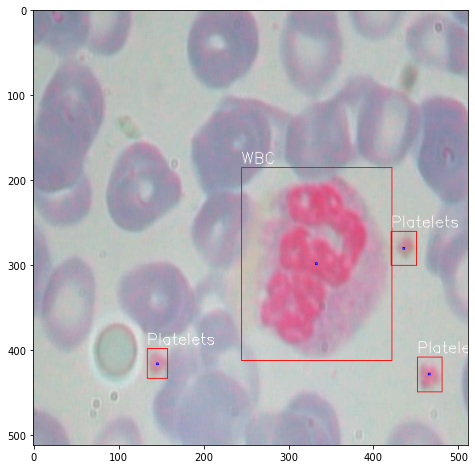

In [12]:
image = data[np.random.randint(len(data))]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(512,512))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box['xmin']*512),int(box['ymin']*512)),
            (int(box['xmax']*512),int(box['ymax']*512)),
            (255,0,0),
            1
        )
    img = cv2.rectangle(
            img,
            (int(box['x']*512)-1,int(box['y']*512)-1),
            (int(box['x']*512)+1,int(box['y']*512)+1),
            (0,0,255),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [13]:
images = np.array([cv2.imread(i['filename']) for i in data])
images = tf.image.resize(images,(512,512),tf.image.ResizeMethod.BICUBIC).numpy() / 255.

### Generating Anchor Grid

In [14]:
"""
> Generates n X n grid for anchor refference.

> Resizing image to a fixed square size helps generating more intuitive grid

> Using Mobilenet Gives a 16 x 16 x 1024 feature tensor for a single 512 x 512
  image so current grid size will be 16 x 16.
 
> Box sizes are used for creating refference anchor boxes, there are three sizes
  in original faster rcnn and 3 different height / width ratios.

> Using 3 box sizes and 3 ratios gives 9 anchors boxes for each grid point.

"""


grid_stride = 32
img_height = 512
img_width = 512

## Grid

h_size,w_size = img_height // grid_stride,img_width // grid_stride 

xx,yy = np.meshgrid(np.arange(w_size),np.arange(h_size))
xx,yy = np.reshape(xx,(h_size,w_size,1)),np.reshape(yy,(h_size,w_size,1))

grid = np.concatenate((yy,xx),axis=-1)
grid = grid * grid_stride

In [15]:
# box_sizes = np.array([64,128,256])
# box_ratios = np.array([0.5,1.,1.5]) # Width to height ratio
# boxes_h = np.matmul(box_sizes.reshape(3,1),box_ratios.reshape(1,3)).reshape(-1,1)
# boxes_w = np.repeat(box_sizes.reshape(3,1),3,axis=1).reshape(-1,1)
# boxes_size = np.concatenate((boxes_h,boxes_w),axis=1).astype(np.uint)

In [16]:
boxes_size = np.array([
    [32,64],
    [48,48],
    [64,32],
    [64,128],
    [96,96],
    [128,64],
    [256,128],
    [192,192],
    [128,256]
])

In [17]:
boxes_size

array([[ 32,  64],
       [ 48,  48],
       [ 64,  32],
       [ 64, 128],
       [ 96,  96],
       [128,  64],
       [256, 128],
       [192, 192],
       [128, 256]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


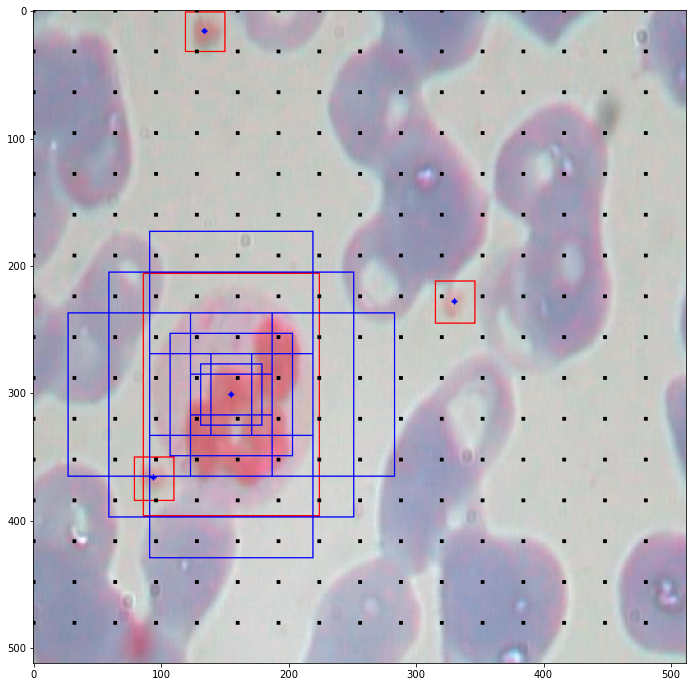

In [23]:
i = np.random.randint(images.shape[0])

img = images[i].copy()

dat = data[i]

for b in dat['boxes']:
    img = cv2.rectangle(
                img,
                (int(b['xmin']*512),int(b['ymin']*512)),
                (int(b['xmax']*512),int(b['ymax']*512)),
                (255,0,0)
        )
    img = cv2.circle(img,(int(b['x']*512),int(b['y']*512)),2,(0,0,255),-1)

b = dat['boxes'][0]
for hh,ww in boxes_size:
    img = cv2.rectangle(
        img,
        (int(b['x']*512) - (ww//2) ,int(b['y']*512) - (hh//2) ),
        (int(b['x']*512) + (ww//2) ,int(b['y']*512) + (hh//2) ),
        (0,0,255),
        1
    )
    
for y,x in grid.reshape((-1,2)):
    img = cv2.rectangle(img,(x-1,y-1),(x+1,y+1),(0,0,0),-1)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [24]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *

In [25]:
inp = Input(shape=(512,512,3))
net = keras.applications.mobilenet.MobileNet(include_top=False,input_tensor=inp,weights="imagenet")

c:\python36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [42]:
net.output_shape

(None, 16, 16, 1024)

In [64]:
"""
> Base for RPN. RPN takes input of feature map and produces region proposals 
  that may have objects in that. 

"""

conf_score = Conv2D(2*9,3,padding="same")(net.output)
box_pred = Conv2D(4*9,3,padding="same")(net.output)

conf_score = Reshape((-1,2))(conf_score)
box_pred = Reshape((-1,4))(box_pred)

conf_score = tf.nn.softmax(conf_score,name="score_predictions")
box_pred = tf.nn.softmax(box_pred,name="box_predictions")



model = keras.Model(inp,[conf_score,box_pred])

In [65]:
model.predict(images[0:1])

[array([[[0.20628622, 0.7937138 ],
         [0.5566281 , 0.44337186],
         [0.68811524, 0.3118847 ],
         ...,
         [0.18326008, 0.8167399 ],
         [0.8624422 , 0.13755782],
         [0.57453746, 0.42546257]]], dtype=float32),
 array([[[0.3473056 , 0.1443259 , 0.31969085, 0.18867764],
         [0.18503563, 0.36011022, 0.30065355, 0.15420064],
         [0.20917393, 0.10486508, 0.39844579, 0.2875152 ],
         ...,
         [0.08899862, 0.06630201, 0.5782937 , 0.26640564],
         [0.17286171, 0.08880231, 0.53773004, 0.20060591],
         [0.09789843, 0.38974753, 0.18450606, 0.32784793]]], dtype=float32)]